# Titanic Kaggle Competition

## Introduction

## Next Steps

1/16 - Maxing out at 82% regardless of what I do with model tuning.  Next step is to go back and mess with the feature engineering to see if I can keep more data.

### Imports

In [292]:
# The standards
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
import shap
shap.initjs()

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC

# Model Validation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score

# Make pandas display all columns
pd.set_option('display.max_columns', None)

# Sklearn Display
from sklearn import set_config
set_config(display = 'diagram')

### Functions

In [293]:
def get_info(df):
    print('-----  Shape  -----')
    print(df.shape)
    print('\n')
    print('-----  Info  -----')
    print(df.info())
    print('\n')
    print('-----  Describe  -----')
    print(df.describe())
    print('\n')
    print('-----  Nulls  -----')
    print(df.isna().sum())
    
    
def evaluate_model(model, X_test, y_test):
    '''Evaluates a sklearn classifier model by displaying a classification report, 
    a confusion matrix plot, and a ROC-AUC plot.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
    
    # Classification Report
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, y_hat_test))
    
    # Confusion Matrix
    fig, axes = plt.subplots(figsize = (12,6), ncols = 2)
    plot_confusion_matrix(model, X_test, y_test, normalize = 'true',
                          cmap = 'Blues', ax = axes[0])#, labels = ['Survived', 'Died'])
    axes[0].set_title('Confusion Matrix');
    
    # ROC-AUC Curve
    roc_auc_plot = plot_roc_curve(model, X_test, y_test, ax = axes[1])
    axes[1].legend()
    axes[1].plot([0,1], [0,1], ls = ':')
    axes[1].grid()
    axes[1].set_title('ROC-AUC Plot')
    fig.tight_layout()
    plt.show();
    

def network_eval_plots(results):
    '''Visualizes the loss and accuracy curves of the training set and validation set.'''
    
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show();
    

def nn_confusion_matrix(y_test, preds):
    '''Creates a confusion matrix specifically for neural networks.'''

    cm = confusion_matrix(y_test, preds, normalize = 'true')
    ax = plt.figure(figsize = (6, 6))
    ax = sns.heatmap(cm, cmap = 'Blues', annot = True,
                     xticklabels = ['Died', 'Survived'],
                     yticklabels = ['Died', 'Survived'])
    ax.set_ylim([0,2])
    
    
def evaluate_network(results, model, X_test, y_test):
    preds = model.predict(X_test).round()
    print('                 Model Evaluation')
    print('-------------------------------------------------------')
    print(model.evaluate(X_test, y_test))
    print(' ')
    print('                 Loss & Accuracy Curves')
    print('-------------------------------------------------------')
    network_eval_plots(results)
    print(' ')
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, preds))
    print(' ')    
    print('                 Confusion Matrix')
    print('-------------------------------------------------------')
    nn_confusion_matrix(y_test, preds)

## Obtain

### Training Data

In [294]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test Data

In [295]:
test_df = pd.read_csv('test.csv')
print(test_df.shape)
test_df.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Scrub

> Just a quick exploration here to see what we're working with.

In [296]:
display(test_df.head())
display(train_df.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [297]:
get_info(train_df)

-----  Shape  -----
(891, 12)


-----  Info  -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


-----  Describe  -----
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0

In [298]:
get_info(test_df)

-----  Shape  -----
(418, 11)


-----  Info  -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


-----  Describe  -----
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0

### Null Values

In [299]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [300]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Feature Selection & Engineering

#### Cabin

In [301]:
train_df['Cabin'].value_counts(1).sort_values(ascending = False) 

B96 B98        0.019608
G6             0.019608
C23 C25 C27    0.019608
E101           0.014706
C22 C26        0.014706
                 ...   
A6             0.004902
B78            0.004902
A20            0.004902
C87            0.004902
C86            0.004902
Name: Cabin, Length: 147, dtype: float64

In [302]:
train_df['Cabin'].fillna(value = 'Missing', inplace = True)
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
dtype: int64

In [303]:
cabin_level = []
for i in train_df['Cabin']:
    i = str(i)
    i = i[0]
    cabin_level.append(i)
    
    
train_df['Cabin Level'] = cabin_level
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin Level
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Missing,S,M
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Missing,S,M
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Missing,S,M


#### Parch & SibSp

In [304]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [305]:
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [306]:
#  Create a new column called Family Size

train_df['Family Size'] = train_df['Parch'] + train_df['SibSp'] + 1
train_df['Family Size'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Family Size, dtype: int64

In [307]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin Level,Family Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Missing,S,M,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Missing,S,M,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Missing,S,M,1


#### Name

> So this could be interesting.  We can make the assumption that each full name on the Titanic is unique.  However, if we were to slice out just the last name, we could see if there is any correlation between last name (family) and survival.

In [308]:
# Checking the assumption that each name is unique.

train_df['Name'].value_counts()

Slayter, Miss. Hilda Mary            1
Madill, Miss. Georgette Alexandra    1
Johansson, Mr. Karl Johan            1
Levy, Mr. Rene Jacques               1
Hodges, Mr. Henry Price              1
                                    ..
Norman, Mr. Robert Douglas           1
Moran, Mr. James                     1
Goldschmidt, Mr. George B            1
Todoroff, Mr. Lalio                  1
Cribb, Mr. John Hatfield             1
Name: Name, Length: 891, dtype: int64

In [309]:
def get_last_names(column):
    last_names = []
    for name in column:
        name = name.split(',')[0]
        last_names.append(name)

    return last_names

In [310]:
train_df['Last Name'] = get_last_names(train_df['Name'])
train_df.drop('Name', axis = 1, inplace = True)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin Level,Family Size,Last Name
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,Missing,S,M,2,Braund
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,C,2,Cumings
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,Missing,S,M,1,Heikkinen
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,C,2,Futrelle
4,5,0,3,male,35.0,0,0,373450,8.0500,Missing,S,M,1,Allen


In [311]:
test_df['Last Name'] = get_last_names(test_df['Name'])
test_df.drop('Name', axis = 1, inplace = True)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q,Kelly
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S,Wilkes
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q,Myles
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S,Wirz
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S,Hirvonen


In [312]:
print(train_df['Last Name'].value_counts())
print(test_df['Last Name'].value_counts())

Andersson      9
Sage           7
Panula         6
Johnson        6
Goodwin        6
              ..
Bostandyeff    1
Samaan         1
Rogers         1
Lindqvist      1
Dakic          1
Name: Last Name, Length: 667, dtype: int64
Ware          4
Sage          4
Davies        4
Thomas        4
Asplund       4
             ..
Bradley       1
Chaudanson    1
Thomson       1
Stokes        1
Lines         1
Name: Last Name, Length: 352, dtype: int64


> As expected, there are multiple people with the same last name, potentially indicating full families on board.

#### Ticket

In [313]:
train_df['Ticket'].value_counts()

347082      7
1601        7
CA. 2343    7
3101295     6
CA 2144     6
           ..
3101277     1
373450      1
233866      1
113051      1
3460        1
Name: Ticket, Length: 681, dtype: int64

#### Age Group
> Let's create a categorical age group column.

In [314]:
#train_df['Age Group'] = train_df['Age'].copy()

In [315]:
# bins = [0, 14, 24, 49, 64, 65]
# labels = ['0-14', '15-24', '25-49', '50-64', '65+']

# train_df['Age Group'] = pd.cut(train_df['Age Group'], bins = bins, labels = labels, right = False)

# train_df.head()

### Train Test Split & Preprocessing

In [316]:
# Create X & y

X = train_df.drop('Survived', axis = 1)
y = train_df['Survived']

In [317]:
# Create train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(668, 13)
(223, 13)
(668,)
(223,)


In [318]:
# Split into numerical and categorical columns

num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('O').columns

In [319]:
# Create pipeline for numerical columns

# num_transformer = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)), 
#                                     ('scaler', StandardScaler())])

num_transformer = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)), 
                                    ('scaler', MinMaxScaler())])

num_transformer

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                ('scaler', MinMaxScaler())])

In [320]:
# Create pipeline for categorical columns

cat_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')), 
                                    ('encoder', OneHotEncoder(handle_unknown = 'ignore', 
                                                              sparse = False))])
cat_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [321]:
# Combine pipelines into a single pipeline

preprocessing = ColumnTransformer(transformers = [('num', num_transformer, num_cols),
                                                  ('cat', cat_transformer, cat_cols)])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=2)),
                                                 ('scaler', MinMaxScaler())]),
                                 Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Family Size'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Sex', 'Ticket', 'Cabin', 'Embarked', 'Cabin Level', 'Last Name'], dtype='object'))])

In [322]:
# Fit the training data with the pipeline

X_train_processed = preprocessing.fit_transform(X_train)
X_test_processed = preprocessing.transform(X_test)

In [323]:
# Put back into a dataframe

slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)

In [324]:
X_train_df = pd.DataFrame(X_train_processed, columns = [*num_cols, *cat_features])
X_test_df = pd.DataFrame(X_test_processed, columns = [*num_cols, *cat_features])

print(X_train_df.shape)
display(X_train_df.head())
print(X_test_df.shape)
display(X_test_df.head())

(668, 1213)


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Family Size,Sex_female,Sex_male,Ticket_110152,Ticket_110413,Ticket_110465,Ticket_110564,Ticket_110813,Ticket_111240,Ticket_111320,Ticket_111361,Ticket_111369,Ticket_111426,Ticket_111427,Ticket_111428,Ticket_112052,Ticket_112053,Ticket_112059,Ticket_112379,Ticket_113028,Ticket_113043,Ticket_113050,Ticket_113051,Ticket_113055,Ticket_113056,Ticket_113059,Ticket_113501,Ticket_113503,Ticket_113505,Ticket_113509,Ticket_113514,Ticket_113572,Ticket_113760,Ticket_113767,Ticket_113773,Ticket_113776,Ticket_113781,Ticket_113783,Ticket_113784,Ticket_113786,Ticket_113789,Ticket_113792,Ticket_113794,Ticket_113796,Ticket_113798,Ticket_113804,Ticket_113806,Ticket_113807,Ticket_11668,Ticket_11751,Ticket_11752,Ticket_11753,Ticket_11755,Ticket_11765,Ticket_11767,Ticket_11769,Ticket_11771,Ticket_11774,Ticket_11813,Ticket_11967,Ticket_12233,Ticket_12460,Ticket_13049,Ticket_13213,Ticket_13214,Ticket_13502,Ticket_13568,Ticket_14312,Ticket_1601,Ticket_16966,Ticket_16988,Ticket_17421,Ticket_17453,Ticket_17463,Ticket_17465,Ticket_17466,Ticket_17474,Ticket_19877,Ticket_19928,Ticket_19950,Ticket_19952,Ticket_19988,Ticket_19996,Ticket_2003,Ticket_218629,Ticket_220367,Ticket_220845,Ticket_223596,Ticket_226593,Ticket_226875,Ticket_230080,Ticket_230136,Ticket_230433,Ticket_230434,Ticket_231919,Ticket_231945,Ticket_233639,Ticket_233866,Ticket_234360,Ticket_234686,Ticket_236171,Ticket_236852,Ticket_237442,Ticket_237565,Ticket_237668,Ticket_237671,Ticket_237736,Ticket_237789,Ticket_237798,Ticket_239853,Ticket_239854,Ticket_239855,Ticket_239865,Ticket_240929,Ticket_24160,Ticket_243847,Ticket_244252,Ticket_244270,Ticket_244278,Ticket_244310,Ticket_244358,Ticket_244361,Ticket_244367,Ticket_244373,Ticket_248706,Ticket_248723,Ticket_248727,Ticket_248738,Ticket_248740,Ticket_250643,Ticket_250644,Ticket_250646,Ticket_250647,Ticket_250648,Ticket_250649,Ticket_250651,Ticket_250653,Ticket_250655,Ticket_2623,Ticket_2624,Ticket_2625,Ticket_2626,Ticket_2627,Ticket_2628,Ticket_2629,Ticket_2631,Ticket_26360,Ticket_2641,Ticket_2647,Ticket_2648,Ticket_2649,Ticket_2650,Ticket_2651,Ticket_2659,Ticket_2661,Ticket_2662,Ticket_2663,Ticket_2664,Ticket_2665,Ticket_2666,Ticket_2667,Ticket_2668,Ticket_2669,Ticket_2671,Ticket_2672,Ticket_2674,Ticket_2677,Ticket_2678,Ticket_2680,Ticket_2683,Ticket_2685,Ticket_2686,Ticket_2687,Ticket_2690,Ticket_2691,Ticket_2693,Ticket_2695,Ticket_2699,Ticket_2700,Ticket_28134,Ticket_28206,Ticket_28213,Ticket_28220,Ticket_28228,Ticket_28403,Ticket_28551,Ticket_29011,Ticket_2908,Ticket_29103,Ticket_29104,Ticket_29105,Ticket_29106,Ticket_29751,Ticket_3101264,Ticket_3101265,Ticket_3101267,Ticket_3101276,Ticket_3101277,Ticket_3101278,Ticket_3101281,Ticket_3101295,Ticket_3101296,Ticket_31027,Ticket_31028,Ticket_312992,Ticket_312993,Ticket_315084,Ticket_315086,Ticket_315088,Ticket_315090,Ticket_315093,Ticket_315094,Ticket_315096,Ticket_315097,Ticket_315098,Ticket_323951,Ticket_330877,Ticket_330909,Ticket_330923,Ticket_330931,Ticket_330932,Ticket_330935,Ticket_330958,Ticket_330959,Ticket_335677,Ticket_33638,Ticket_336439,Ticket_3411,Ticket_341826,Ticket_34218,Ticket_342826,Ticket_343095,Ticket_343120,Ticket_343275,Ticket_343276,Ticket_345364,Ticket_345572,Ticket_345763,Ticket_345764,Ticket_345765,Ticket_345769,Ticket_345770,Ticket_345773,Ticket_345774,Ticket_345777,Ticket_345778,Ticket_345779,Ticket_345781,Ticket_345783,Ticket_3460,Ticket_347054,Ticket_347061,Ticket_347062,Ticket_347063,Ticket_347064,Ticket_347067,Ticket_347068,Ticket_347069,Ticket_347071,Ticket_347073,Ticket_347074,Ticket_347077,Ticket_347078,Ticket_347080,Ticket_347081,Ticket_347082,Ticket_347083,Ticket_347085,Ticket_347087,Ticket_347088,Ticket_347089,Ticket_3474,Ticket_347466,Ticket_347468,Ticket_347470,Ticket_347742,Ticket_347743,Ticket_348123,Ticket_348124,Ticket_349201,Ticket_349203,Ticket_349204,Ticket_349205,Ticket_349206,Ticket_349207,Ticket_349209,Ticket_349212,Ticket_349213,Ticket_349216,Ticket_349218,Ticket_349219,Ticket_349221,Ticket_349222,Tic

(223, 1213)


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Family Size,Sex_female,Sex_male,Ticket_110152,Ticket_110413,Ticket_110465,Ticket_110564,Ticket_110813,Ticket_111240,Ticket_111320,Ticket_111361,Ticket_111369,Ticket_111426,Ticket_111427,Ticket_111428,Ticket_112052,Ticket_112053,Ticket_112059,Ticket_112379,Ticket_113028,Ticket_113043,Ticket_113050,Ticket_113051,Ticket_113055,Ticket_113056,Ticket_113059,Ticket_113501,Ticket_113503,Ticket_113505,Ticket_113509,Ticket_113514,Ticket_113572,Ticket_113760,Ticket_113767,Ticket_113773,Ticket_113776,Ticket_113781,Ticket_113783,Ticket_113784,Ticket_113786,Ticket_113789,Ticket_113792,Ticket_113794,Ticket_113796,Ticket_113798,Ticket_113804,Ticket_113806,Ticket_113807,Ticket_11668,Ticket_11751,Ticket_11752,Ticket_11753,Ticket_11755,Ticket_11765,Ticket_11767,Ticket_11769,Ticket_11771,Ticket_11774,Ticket_11813,Ticket_11967,Ticket_12233,Ticket_12460,Ticket_13049,Ticket_13213,Ticket_13214,Ticket_13502,Ticket_13568,Ticket_14312,Ticket_1601,Ticket_16966,Ticket_16988,Ticket_17421,Ticket_17453,Ticket_17463,Ticket_17465,Ticket_17466,Ticket_17474,Ticket_19877,Ticket_19928,Ticket_19950,Ticket_19952,Ticket_19988,Ticket_19996,Ticket_2003,Ticket_218629,Ticket_220367,Ticket_220845,Ticket_223596,Ticket_226593,Ticket_226875,Ticket_230080,Ticket_230136,Ticket_230433,Ticket_230434,Ticket_231919,Ticket_231945,Ticket_233639,Ticket_233866,Ticket_234360,Ticket_234686,Ticket_236171,Ticket_236852,Ticket_237442,Ticket_237565,Ticket_237668,Ticket_237671,Ticket_237736,Ticket_237789,Ticket_237798,Ticket_239853,Ticket_239854,Ticket_239855,Ticket_239865,Ticket_240929,Ticket_24160,Ticket_243847,Ticket_244252,Ticket_244270,Ticket_244278,Ticket_244310,Ticket_244358,Ticket_244361,Ticket_244367,Ticket_244373,Ticket_248706,Ticket_248723,Ticket_248727,Ticket_248738,Ticket_248740,Ticket_250643,Ticket_250644,Ticket_250646,Ticket_250647,Ticket_250648,Ticket_250649,Ticket_250651,Ticket_250653,Ticket_250655,Ticket_2623,Ticket_2624,Ticket_2625,Ticket_2626,Ticket_2627,Ticket_2628,Ticket_2629,Ticket_2631,Ticket_26360,Ticket_2641,Ticket_2647,Ticket_2648,Ticket_2649,Ticket_2650,Ticket_2651,Ticket_2659,Ticket_2661,Ticket_2662,Ticket_2663,Ticket_2664,Ticket_2665,Ticket_2666,Ticket_2667,Ticket_2668,Ticket_2669,Ticket_2671,Ticket_2672,Ticket_2674,Ticket_2677,Ticket_2678,Ticket_2680,Ticket_2683,Ticket_2685,Ticket_2686,Ticket_2687,Ticket_2690,Ticket_2691,Ticket_2693,Ticket_2695,Ticket_2699,Ticket_2700,Ticket_28134,Ticket_28206,Ticket_28213,Ticket_28220,Ticket_28228,Ticket_28403,Ticket_28551,Ticket_29011,Ticket_2908,Ticket_29103,Ticket_29104,Ticket_29105,Ticket_29106,Ticket_29751,Ticket_3101264,Ticket_3101265,Ticket_3101267,Ticket_3101276,Ticket_3101277,Ticket_3101278,Ticket_3101281,Ticket_3101295,Ticket_3101296,Ticket_31027,Ticket_31028,Ticket_312992,Ticket_312993,Ticket_315084,Ticket_315086,Ticket_315088,Ticket_315090,Ticket_315093,Ticket_315094,Ticket_315096,Ticket_315097,Ticket_315098,Ticket_323951,Ticket_330877,Ticket_330909,Ticket_330923,Ticket_330931,Ticket_330932,Ticket_330935,Ticket_330958,Ticket_330959,Ticket_335677,Ticket_33638,Ticket_336439,Ticket_3411,Ticket_341826,Ticket_34218,Ticket_342826,Ticket_343095,Ticket_343120,Ticket_343275,Ticket_343276,Ticket_345364,Ticket_345572,Ticket_345763,Ticket_345764,Ticket_345765,Ticket_345769,Ticket_345770,Ticket_345773,Ticket_345774,Ticket_345777,Ticket_345778,Ticket_345779,Ticket_345781,Ticket_345783,Ticket_3460,Ticket_347054,Ticket_347061,Ticket_347062,Ticket_347063,Ticket_347064,Ticket_347067,Ticket_347068,Ticket_347069,Ticket_347071,Ticket_347073,Ticket_347074,Ticket_347077,Ticket_347078,Ticket_347080,Ticket_347081,Ticket_347082,Ticket_347083,Ticket_347085,Ticket_347087,Ticket_347088,Ticket_347089,Ticket_3474,Ticket_347466,Ticket_347468,Ticket_347470,Ticket_347742,Ticket_347743,Ticket_348123,Ticket_348124,Ticket_349201,Ticket_349203,Ticket_349204,Ticket_349205,Ticket_349206,Ticket_349207,Ticket_349209,Ticket_349212,Ticket_349213,Ticket_349216,Ticket_349218,Ticket_349219,Ticket_349221,Ticket_349222,Tic

## Explore

In [325]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

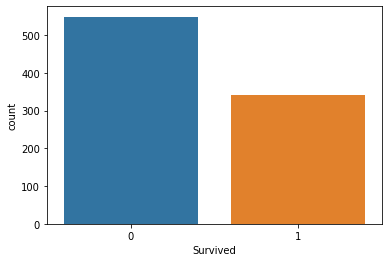

In [326]:
sns.countplot(data = train_df, x = 'Survived');

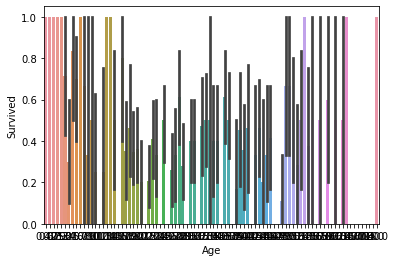

In [327]:
sns.barplot(data = train_df, x = 'Age', y = 'Survived');

## Modeling

### Logistic Regression

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       131
           1       0.75      0.75      0.75        92

    accuracy                           0.79       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.79      0.79      0.79       223



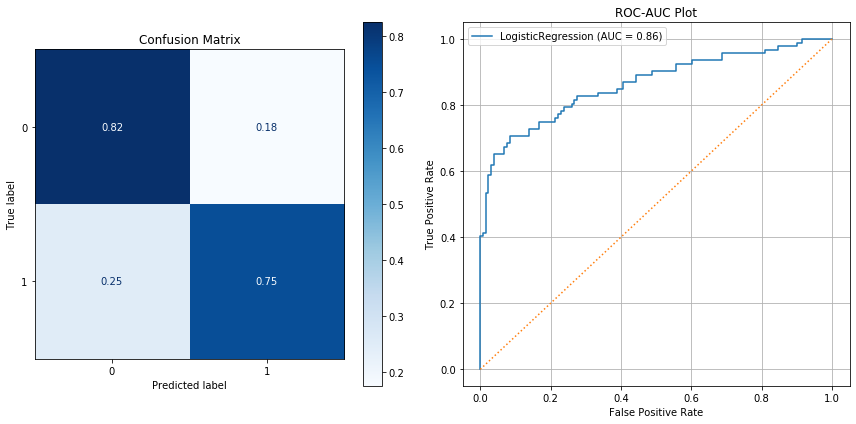

In [328]:
# Fit a base logistic regression model

logreg = LogisticRegression(class_weight = 'balanced')
logreg.fit(X_train_df, y_train)

# Evaluate model
evaluate_model(logreg, X_test_df, y_test)

#### GridSearchCV

In [329]:
# Let's try using gridsearch to see if we can kick this up a notch

params = {'class_weight': ['balanced'],
          'solver' : ['lbfgs', 'liblinear', 'newton-cg'],
          'max_iter': [100, 200, 500],
          'penalty': ['l1', 'l2', 'none']}

logreg_grid = GridSearchCV(estimator = LogisticRegression(),
                           param_grid = params,
                           cv = 3,
                           n_jobs = -1)

logreg_grid.fit(X_train_df, y_train)

print(logreg_grid.best_estimator_.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       131
           1       0.75      0.73      0.74        92

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



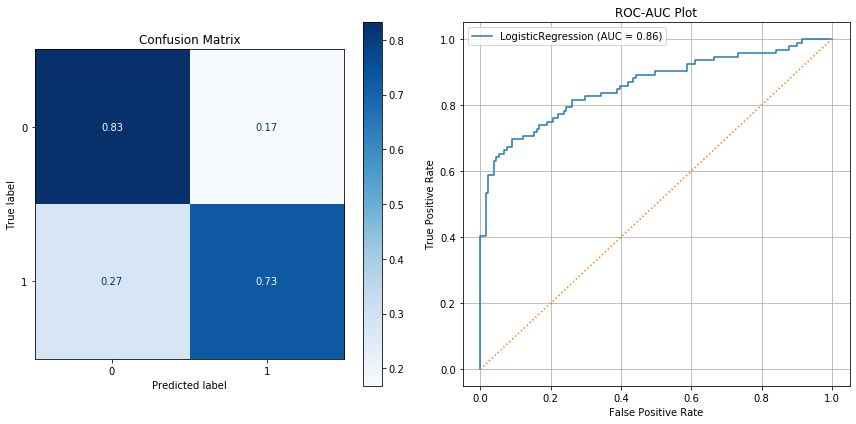

In [330]:
# Fit the model using the best parameters

best_logreg_params = logreg_grid.best_params_
best_logreg_model = LogisticRegression(**best_logreg_params)
best_logreg_model.fit(X_train_df, y_train)

# Evaluate the model
evaluate_model(best_logreg_model, X_test_df, y_test)

### Decision Tree

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       131
           1       0.76      0.73      0.74        92

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.79      0.79      0.79       223



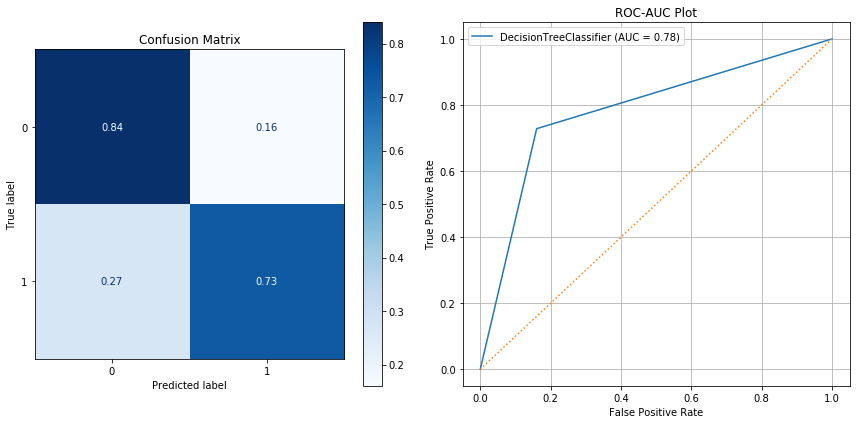

In [331]:
# Fitting a base Decision Tree

tree = DecisionTreeClassifier(class_weight = 'balanced')
tree.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(tree, X_test_df, y_test)

#### GridsearchCV

In [332]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'class_weight' : ['balanced'],
          'splitter' : ['best', 'random'],
          'max_features': [None, "auto", "sqrt", "log2"],
          'criterion': ['gini', 'entropy'],
          'max_depth' : [1, 5, 10, 25], 
          'min_samples_split' : [2, 5, 10],
          'min_samples_leaf' : [1, 5, 10]}

tree_grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

tree_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(tree_grid.best_estimator_.get_params())

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'random'}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       131
           1       0.71      0.73      0.72        92

    accuracy                           0.77       223
   macro avg       0.76      0.76      0.76       223
weighted avg       0.77      0.77      0.77       223



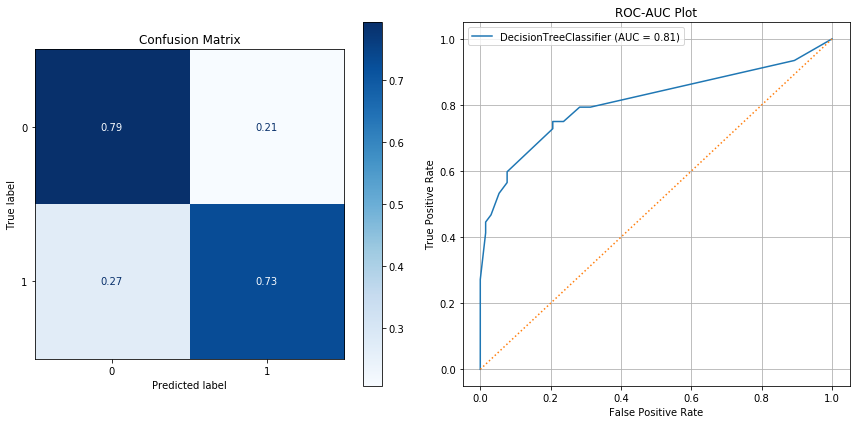

In [333]:
# Fit new model with the best hyperparameters

best_tree_params = tree_grid.best_params_
best_tree_model = DecisionTreeClassifier(**best_tree_params)
best_tree_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_tree_model, X_test_df, y_test)

### KNeighbors Classifier

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       131
           1       0.81      0.65      0.72        92

    accuracy                           0.79       223
   macro avg       0.80      0.77      0.78       223
weighted avg       0.80      0.79      0.79       223



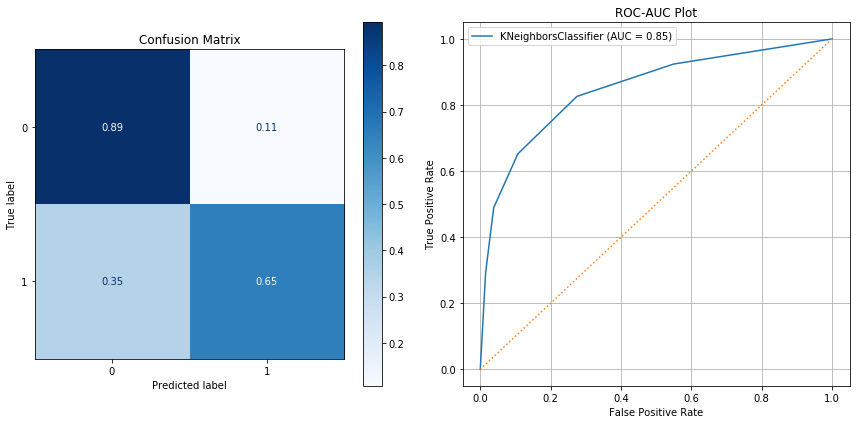

In [334]:
knn = KNeighborsClassifier()
knn.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(knn, X_test_df, y_test)

#### GridsearchCV

In [335]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'n_neighbors' : [1, 2, 3, 4, 5],
          'weights' : ['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'leaf_size': [10, 30, 50]}

knn_grid = GridSearchCV(estimator = KNeighborsClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

knn_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(knn_grid.best_estimator_.get_params())

{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       131
           1       0.81      0.71      0.76        92

    accuracy                           0.81       223
   macro avg       0.81      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



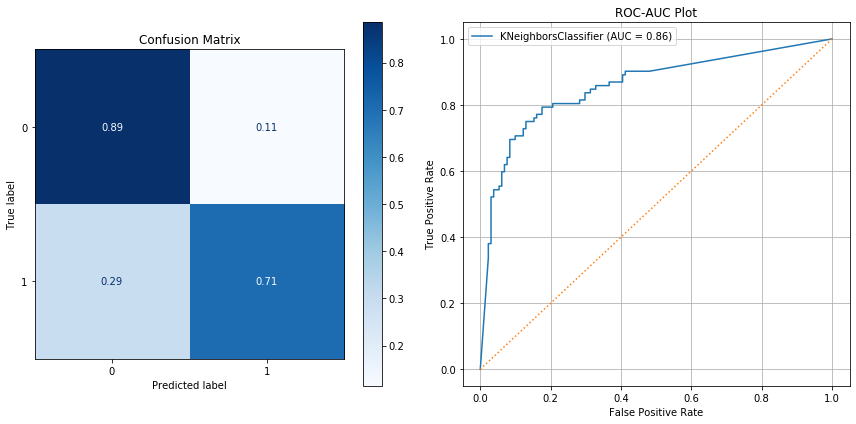

In [336]:
# Fit new model with the best hyperparameters

best_knn_params = knn_grid.best_params_
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_knn_model, X_test_df, y_test)

### MLP Classifier

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       131
           1       0.77      0.72      0.74        92

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



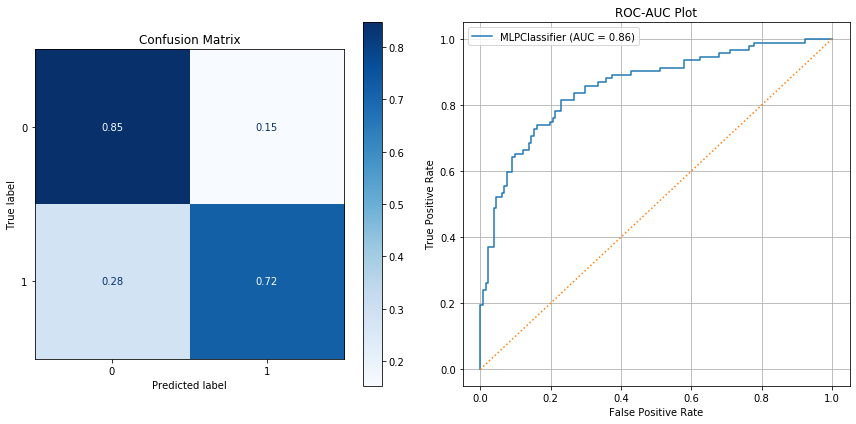

In [337]:
mlp = MLPClassifier()
mlp.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(mlp, X_test_df, y_test)

#### GridsearchCV

In [338]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'hidden_layer_sizes' : [(100,), (200,), (300,)],
          'activation' : ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['lbfgs', 'sgd', 'adam'],
          'learning_rate': ['constant', 'invscaling', 'adaptive'],
          'early_stopping': [True, False],
          'learning_rate': ['constant', 'invscaling', 'adaptive'],
         }

mlp_grid = GridSearchCV(estimator = MLPClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

mlp_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(mlp_grid.best_estimator_.get_params())

{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       131
           1       0.86      0.68      0.76        92

    accuracy                           0.83       223
   macro avg       0.83      0.80      0.81       223
weighted avg       0.83      0.83      0.82       223



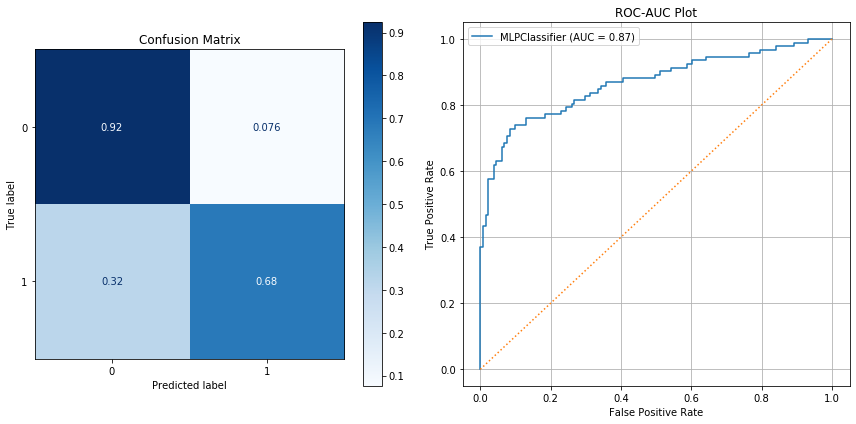

In [339]:
# Fit new model with the best hyperparameters

best_mlp_params = mlp_grid.best_params_
best_mlp_model = MLPClassifier(**best_mlp_params)
best_mlp_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_mlp_model, X_test_df, y_test)

### Guassian Process Classifier

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       131
           1       0.78      0.67      0.73        92

    accuracy                           0.79       223
   macro avg       0.79      0.77      0.78       223
weighted avg       0.79      0.79      0.79       223



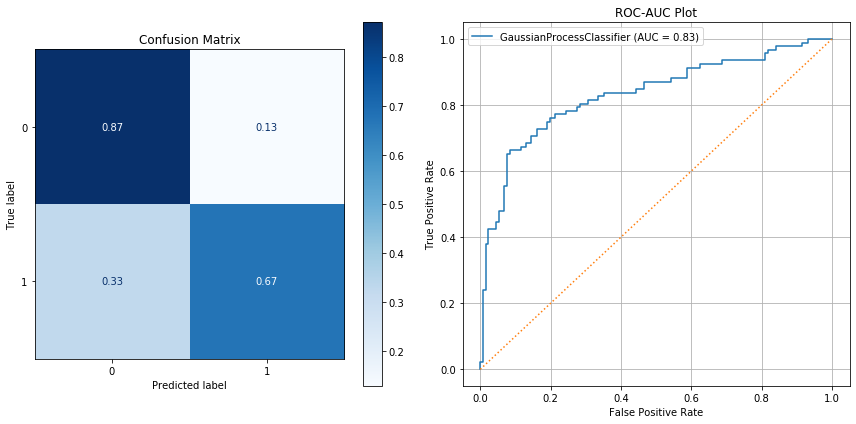

In [340]:
gpc = GaussianProcessClassifier()
gpc.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(gpc, X_test_df, y_test)

#### GridsearchCV

In [341]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'n_restarts_optimizer' : [0, 1, 2],
          'max_iter_predict' : [25, 50, 100, 200]
         }

gcp_grid = GridSearchCV(estimator = GaussianProcessClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

gcp_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(gcp_grid.best_estimator_.get_params())

{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 25, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       131
           1       0.78      0.67      0.73        92

    accuracy                           0.79       223
   macro avg       0.79      0.77      0.78       223
weighted avg       0.79      0.79      0.79       223



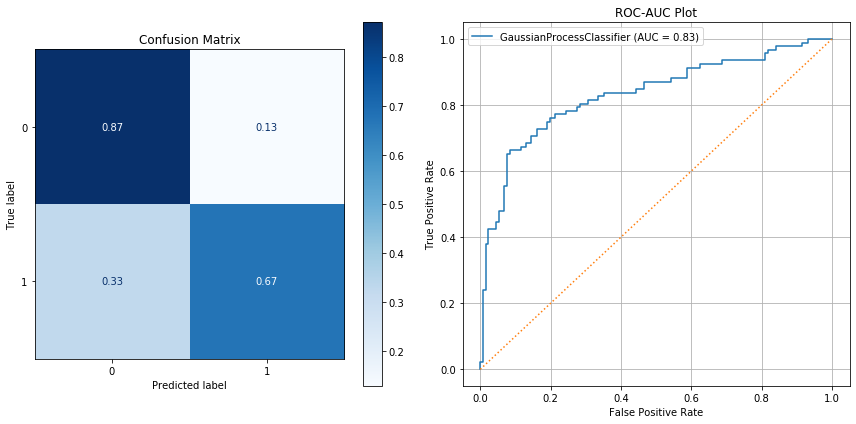

In [342]:
# Fit new model with the best hyperparameters

best_gcp_params = gcp_grid.best_params_
best_gcp_model = GaussianProcessClassifier(**best_gcp_params)
best_gcp_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_gcp_model, X_test_df, y_test)

### Naive Bayes

#### GaussianNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.27      0.40       131
           1       0.46      0.88      0.60        92

    accuracy                           0.52       223
   macro avg       0.61      0.58      0.50       223
weighted avg       0.64      0.52      0.49       223



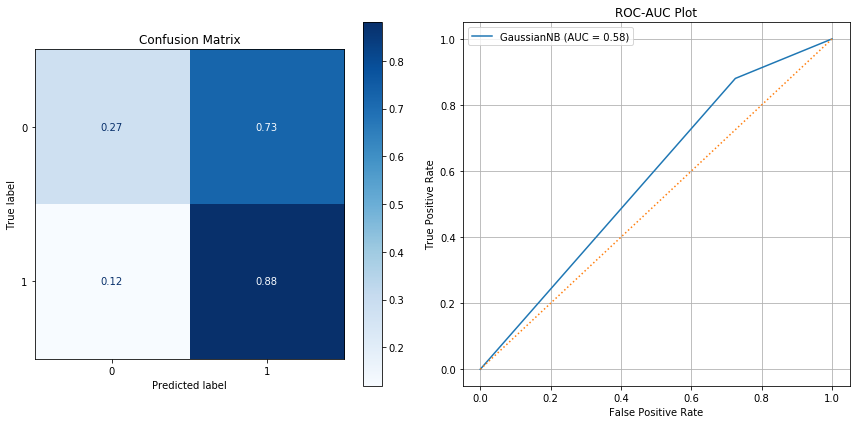

In [343]:
# Fitting a base random forest model

gaussiannb = GaussianNB()
gaussiannb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(gaussiannb, X_test_df, y_test)

#### BernoulliNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       131
           1       0.82      0.49      0.61        92

    accuracy                           0.74       223
   macro avg       0.77      0.71      0.71       223
weighted avg       0.76      0.74      0.73       223



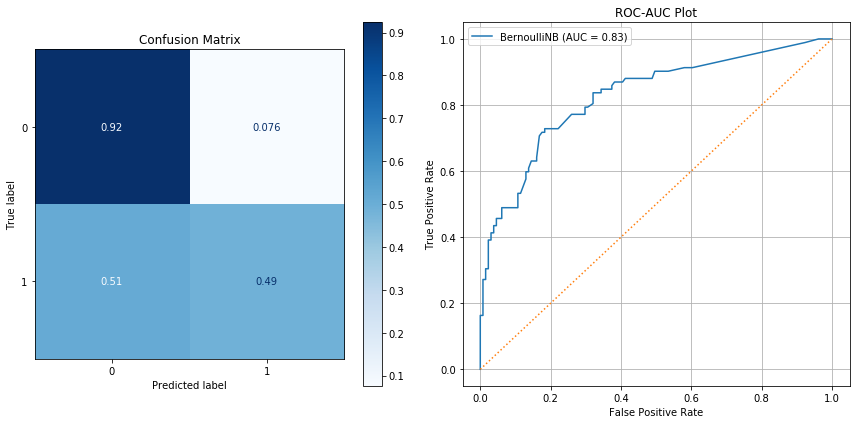

In [344]:
bernoullinb = BernoulliNB()
bernoullinb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(bernoullinb, X_test_df, y_test)

#### ComplementNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       131
           1       0.83      0.49      0.62        92

    accuracy                           0.75       223
   macro avg       0.78      0.71      0.71       223
weighted avg       0.77      0.75      0.73       223



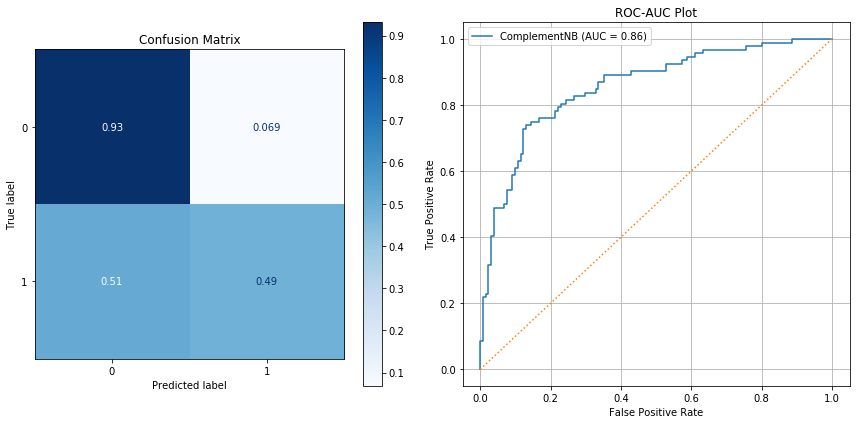

In [345]:
complementnb = ComplementNB()
complementnb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(complementnb, X_test_df, y_test)

#### MultinomialNB

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.96      0.82       131
           1       0.89      0.46      0.60        92

    accuracy                           0.75       223
   macro avg       0.80      0.71      0.71       223
weighted avg       0.79      0.75      0.73       223



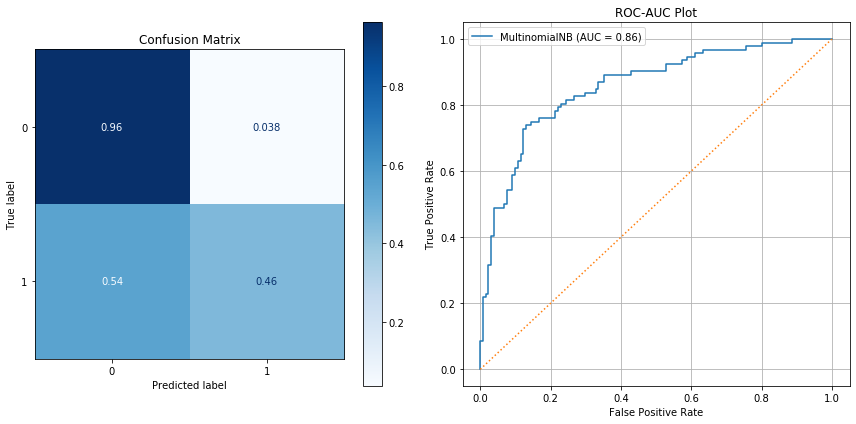

In [346]:
multinomialnb = MultinomialNB()
multinomialnb.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(multinomialnb, X_test_df, y_test)

### Suppor Vector Machine

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       131
           1       0.73      0.71      0.72        92

    accuracy                           0.77       223
   macro avg       0.76      0.76      0.76       223
weighted avg       0.77      0.77      0.77       223



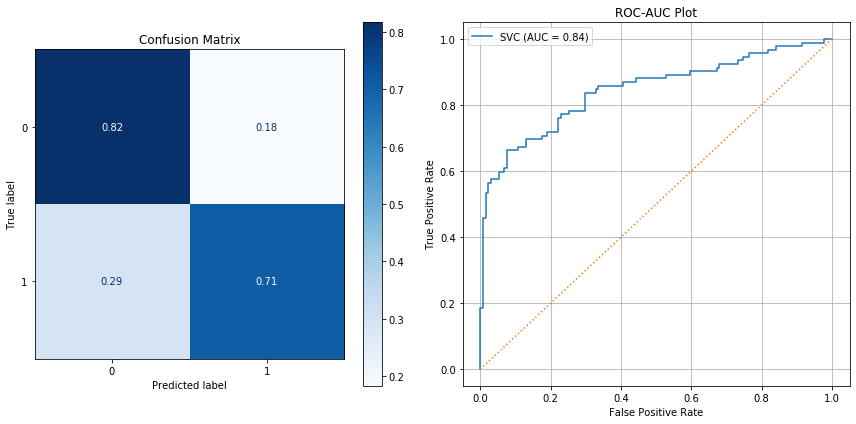

In [347]:
svc = SVC(class_weight = 'balanced')
svc.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(svc, X_test_df, y_test)

#### GridsearchCV

In [348]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'class_weight' : ['balanced'],
          'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma': ['scale', 'auto'],
          'decision_function_shape' : ['ovo', 'ovr'],
          'C' : [0.1, 1, 10, 100, 1000],
         }

svc_grid = GridSearchCV(estimator = SVC(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

svc_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(svc_grid.best_estimator_.get_params())

{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       131
           1       0.79      0.68      0.73        92

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



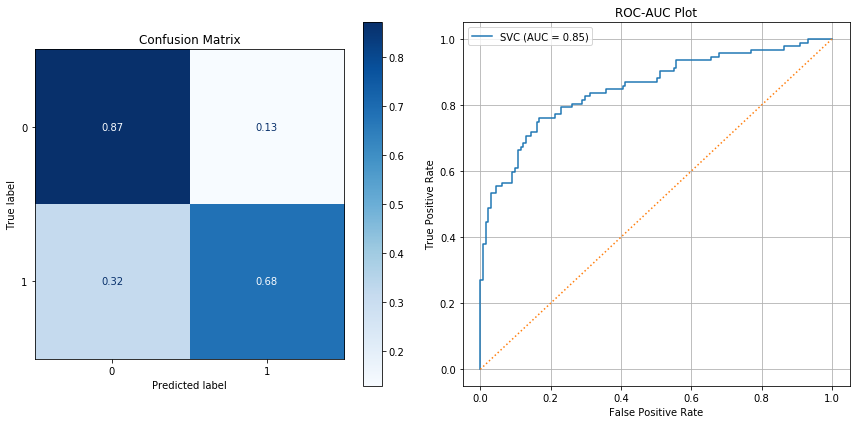

In [349]:
# Fit new model with the best hyperparameters

best_svc_params = svc_grid.best_params_
best_svc_model = SVC(**best_svc_params)
best_svc_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_svc_model, X_test_df, y_test)

### AdaBoost

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       131
           1       0.83      0.65      0.73        92

    accuracy                           0.80       223
   macro avg       0.81      0.78      0.79       223
weighted avg       0.81      0.80      0.80       223



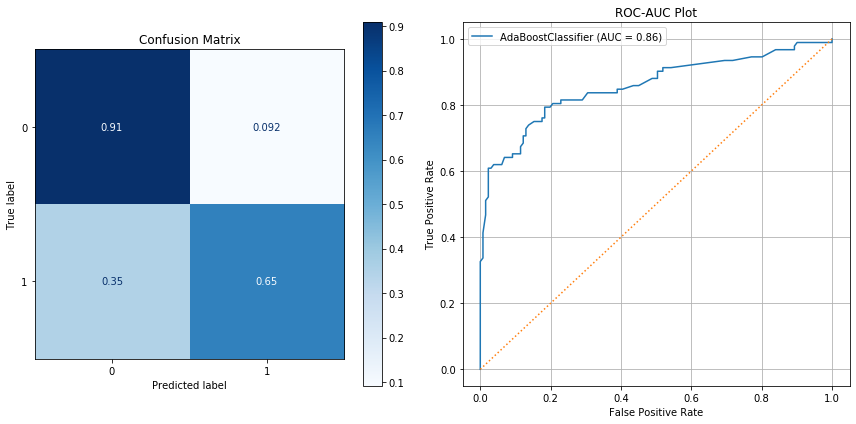

In [350]:
# Fitting a base random forest model

adaboost = AdaBoostClassifier()
adaboost.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(adaboost, X_test_df, y_test)

#### GridsearchCV

In [351]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'n_estimators' : [10, 100, 250, 500]}

ada_grid = GridSearchCV(estimator = AdaBoostClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

ada_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(ada_grid.best_estimator_.get_params())

{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 500, 'random_state': None}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       131
           1       0.83      0.74      0.78        92

    accuracy                           0.83       223
   macro avg       0.83      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223



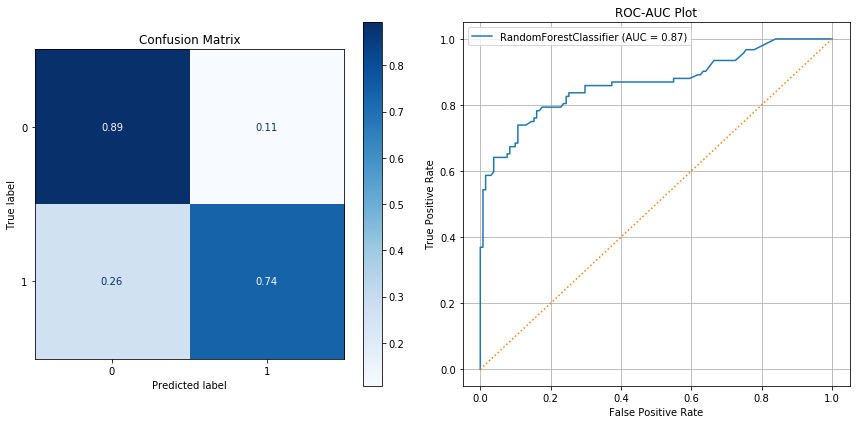

In [352]:
# Fit new model with the best hyperparameters

best_ada_params = ada_grid.best_params_
best_ada_model = RandomForestClassifier(**best_ada_params)
best_ada_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_ada_model, X_test_df, y_test)

### Random Forest

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       131
           1       0.80      0.72      0.76        92

    accuracy                           0.81       223
   macro avg       0.81      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



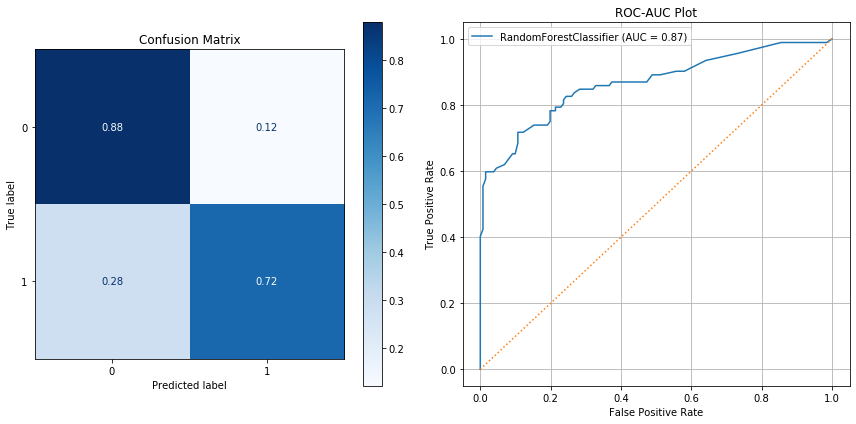

In [353]:
# Fitting a base random forest model

random_forest = RandomForestClassifier(class_weight = 'balanced')
random_forest.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(random_forest, X_test_df, y_test)

#### GridsearchCV

In [354]:
# Let's try a gridsearch to see if we can kick this up a notch

params = {'class_weight' : ['balanced', 'balanced_subsample'],
          'n_estimators' : [10, 100, 250, 500],
          'criterion': ['gini', 'entropy'],
          'max_depth' : [1, 5, 10, 25], 
          'min_samples_split' : [2, 5, 10],
          'min_samples_leaf' : [1, 5, 10]}

rf_grid = GridSearchCV(estimator = RandomForestClassifier(),
                    param_grid = params, 
                    cv = 3,
                    n_jobs = -1)

rf_grid.fit(X_train_df, y_train)

# Check the best hyperparameters
print(rf_grid.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       131
           1       0.76      0.74      0.75        92

    accuracy                           0.79       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.79      0.79      0.79       223



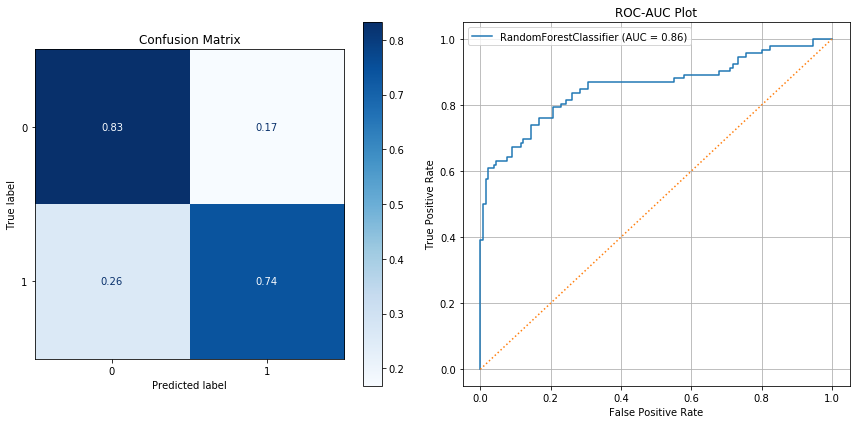

In [355]:
# Fit new model with the best hyperparameters

best_rf_params = rf_grid.best_params_
best_rf_model = RandomForestClassifier(**best_rf_params)
best_rf_model.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(best_rf_model, X_test_df, y_test)

### XGBoost

#### Base Model

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       131
           1       0.83      0.71      0.76        92

    accuracy                           0.82       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



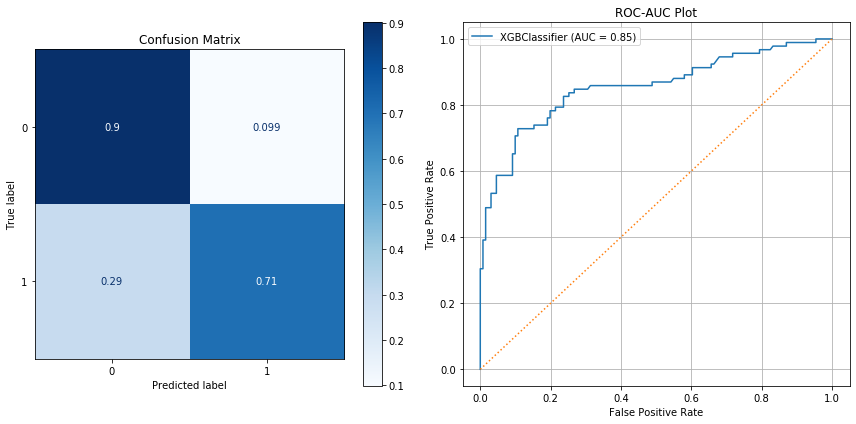

In [356]:
# Fitting a base xgboost model

xgboost = xgb.XGBClassifier()
xgboost.fit(X_train_df, y_train)

# Evaluate model

evaluate_model(xgboost, X_test_df, y_test)

#### GridsearchCV

In [357]:
# # Let's gridsearch this thing

# params = {'booster': ['gbtree', 'gblinear', 'dart'],
#           'gamma': [0, 0.5, 1, 2, 5],
#           'max_delta_step': [0, 1, 2, 5],
#           'max_depth' : [1, 5, 10, 25],
#           'n_estimators': [10, 50, 100, 200]}

# xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(),
#                         param_grid = params, 
#                         cv = 3, 
#                         n_jobs = -1)

# xgb_grid.fit(X_train_df, y_train)

# # Check out the best parameters
# print(xgb_grid.best_estimator_.get_params())

In [358]:
# # Fit the model with the best parameters

# best_xgb_params = xgb_grid.best_params_
# best_xgb_model = xgb.XGBClassifier(**best_xgb_params)
# best_xgb_model.fit(X_train_df, y_train)

# # Evaluate Model
# evaluate_model(best_xgb_model, X_test_df, y_test)

### Stacking Classifier

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       131
           1       0.81      0.74      0.77        92

    accuracy                           0.82       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.82      0.82       223



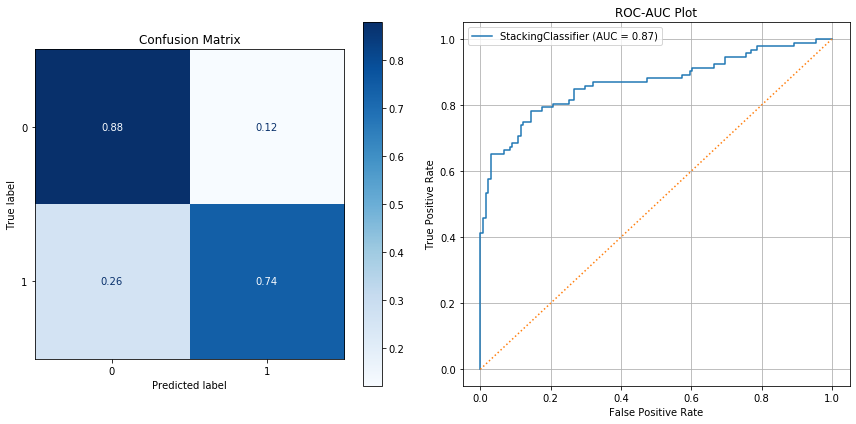

In [365]:
# Set up the stack

# Estimators made up of best performing models

estimators = [('mlp', best_mlp_model),
              ('ada', best_ada_model),
              ('rf', best_rf_model),
              ('xgb', xgboost)]


# Fit the model

stack = StackingClassifier(estimators = estimators, 
                           final_estimator = LogisticRegression(),
                           cv = 5,
                           n_jobs = -1)

stack.fit(X_train_df, y_train)

# Evaluate Model

evaluate_model(stack, X_test_df, y_test)

### Deep Neural Network

### Base Model

W0116 16:57:56.951430 140735933940608 functional.py:587] Model was constructed with shape (None, 668, 1213) for input Tensor("dense_39_input:0", shape=(None, 668, 1213), dtype=float32), but it was called on an input with incompatible shape (None, 1213).


Epoch 1/100


W0116 16:57:57.203486 140735933940608 functional.py:587] Model was constructed with shape (None, 668, 1213) for input Tensor("dense_39_input:0", shape=(None, 668, 1213), dtype=float32), but it was called on an input with incompatible shape (None, 1213).


26/30 [=========================>....] - ETA: 0s - loss: 0.6726 - accuracy: 0.6082

W0116 16:57:58.350943 140735933940608 functional.py:587] Model was constructed with shape (None, 668, 1213) for input Tensor("dense_39_input:0", shape=(None, 668, 1213), dtype=float32), but it was called on an input with incompatible shape (None, 1213).


30/30 [==============================] - 1s 31ms/step - loss: 0.6700 - accuracy: 0.6146 - val_loss: 0.6372 - val_accuracy: 0.6169
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6188 - val_loss: 0.5854 - val_accuracy: 0.6169
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5818 - accuracy: 0.6681 - val_loss: 0.5409 - val_accuracy: 0.6965
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5437 - accuracy: 0.7452 - val_loss: 0.5057 - val_accuracy: 0.7811
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4734 - accuracy: 0.7666 - val_loss: 0.5097 - val_accuracy: 0.7512
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4111 - accuracy: 0.8330 - val_loss: 0.4577 - val_accuracy: 0.8109
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3190 - accuracy: 0.8887 - val_loss: 0.4665 - val_accuracy: 0.8259
Epoch 8/100
30/30 [=====

W0116 16:58:00.191491 140735933940608 functional.py:587] Model was constructed with shape (None, 668, 1213) for input Tensor("dense_39_input:0", shape=(None, 668, 1213), dtype=float32), but it was called on an input with incompatible shape (None, 1213).


                 Model Evaluation
-------------------------------------------------------
7/7 [==============================] - 0s 2ms/step - loss: 0.5520 - accuracy: 0.7668
[0.552040696144104, 0.7668161392211914]
 
                 Loss & Accuracy Curves
-------------------------------------------------------


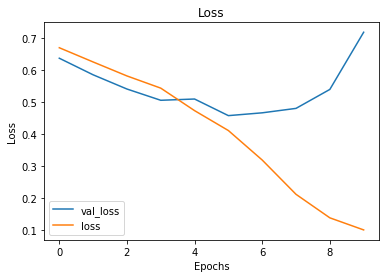

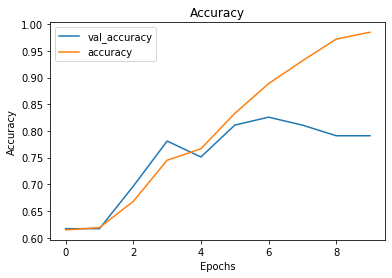

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       131
           1       0.76      0.63      0.69        92

    accuracy                           0.77       223
   macro avg       0.77      0.75      0.75       223
weighted avg       0.77      0.77      0.76       223

 
                 Confusion Matrix
-------------------------------------------------------


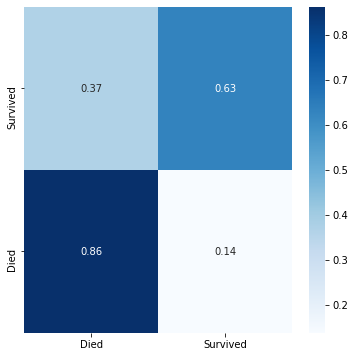

In [366]:
# Model Architecture

# Early Stopping
callback = EarlyStopping(monitor = 'val_accuracy', patience = 3, mode = 'max',
                         min_delta = 0.01, restore_best_weights = True)

# Create base model
model = Sequential()

# Input layer
model.add(Dense(128, input_shape = X_train_df.shape, activation = 'relu'))

# Hidden layers
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(8, activation = 'relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Compile 
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

# Fit the model
history = model.fit(X_train_df, y_train, batch_size = 16, epochs = 100,
                    validation_split = 0.3, callbacks = callback, workers = 16)

# Evaluate the model
evaluate_network(history, model, X_test_df, y_test)

### Model with Adjusted Class Weights

In [367]:
from sklearn.utils import class_weight

In [368]:
np.unique(y_train)

array([0, 1])

In [369]:
class_weights = dict(zip(np.unique(y_train),class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)))

W0116 16:58:02.820088 140735933940608 functional.py:587] Model was constructed with shape (None, 668, 1213) for input Tensor("dense_44_input:0", shape=(None, 668, 1213), dtype=float32), but it was called on an input with incompatible shape (None, 1213).


Epoch 1/50


W0116 16:58:03.071909 140735933940608 functional.py:587] Model was constructed with shape (None, 668, 1213) for input Tensor("dense_44_input:0", shape=(None, 668, 1213), dtype=float32), but it was called on an input with incompatible shape (None, 1213).


18/30 [=================>............] - ETA: 0s - loss: 0.7919 - accuracy: 0.6146

W0116 16:58:04.277159 140735933940608 functional.py:587] Model was constructed with shape (None, 668, 1213) for input Tensor("dense_44_input:0", shape=(None, 668, 1213), dtype=float32), but it was called on an input with incompatible shape (None, 1213).


30/30 [==============================] - 1s 33ms/step - loss: 0.7444 - accuracy: 0.6253 - val_loss: 0.4815 - val_accuracy: 0.7960
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6702 - val_loss: 0.4436 - val_accuracy: 0.8060
Epoch 3/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6052 - accuracy: 0.7109 - val_loss: 0.4390 - val_accuracy: 0.8060
Epoch 4/50
30/30 [==============================] - 0s 5ms/step - loss: 0.6126 - accuracy: 0.7409 - val_loss: 0.4305 - val_accuracy: 0.8109
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.5565 - accuracy: 0.7323 - val_loss: 0.4256 - val_accuracy: 0.8159
Epoch 6/50
30/30 [==============================] - 0s 5ms/step - loss: 0.5450 - accuracy: 0.7473 - val_loss: 0.4243 - val_accuracy: 0.8060
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.5567 - accuracy: 0.7559 - val_loss: 0.4216 - val_accuracy: 0.8109
Epoch 8/50
30/30 [============

W0116 16:58:07.155864 140735933940608 functional.py:587] Model was constructed with shape (None, 668, 1213) for input Tensor("dense_44_input:0", shape=(None, 668, 1213), dtype=float32), but it was called on an input with incompatible shape (None, 1213).


                 Model Evaluation
-------------------------------------------------------
7/7 [==============================] - 0s 2ms/step - loss: 0.4997 - accuracy: 0.7713
[0.499712198972702, 0.7713004350662231]
 
                 Loss & Accuracy Curves
-------------------------------------------------------


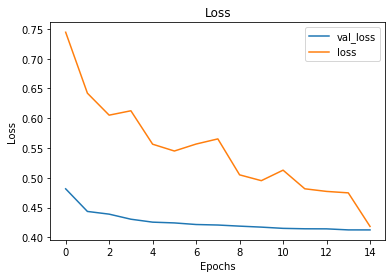

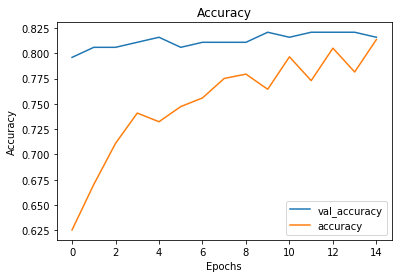

 
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       131
           1       0.75      0.67      0.71        92

    accuracy                           0.77       223
   macro avg       0.77      0.76      0.76       223
weighted avg       0.77      0.77      0.77       223

 
                 Confusion Matrix
-------------------------------------------------------


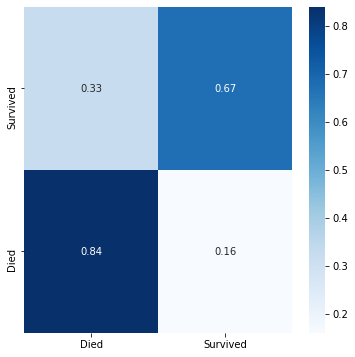

In [370]:
# Model Architecture

# Early Stopping
callback = EarlyStopping(monitor = 'val_accuracy', patience = 5, mode = 'max',
                         min_delta = 0.001, restore_best_weights = True)

# Create base model
model = Sequential()

# Input layer
model.add(Dense(256, input_shape = X_train_df.shape, activation = 'tanh'))
#model.add(Dense(256, input_shape = (668, 1086), activation = 'tanh'))

# Hidden layers
model.add(Dense(128, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation = 'selu'))
model.add(Dropout(0.3))

model.add(Dense(8, activation = 'selu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation = 'sigmoid'))

# Compile 
model.compile(optimizer = 'adagrad', loss = 'binary_crossentropy', metrics = 'accuracy')

# Fit the model
history = model.fit(X_train_df, y_train, batch_size = 16, epochs = 50,
                    validation_split = 0.3, class_weight = class_weights, 
                    workers = 16, callbacks = callback)

# Evaluate the model
evaluate_network(history, model, X_test_df, y_test)

<center><h3> Next step: Gridsearch using kerasclassifier!</h3></center>

In [241]:
# Make a build function for a neural network

def build_network(activation, activation_2, neurons_1, neurons_2,
                  neurons_3, neurons_4, neurons_5, optimizer, epochs, batch_size):
    # Create model
    model = Sequential()
    
    # Input layer
    model.add(Dense(neurons_1, input_shape = (668, 1086), activation = activation))

    # Hidden layers
    model.add(Dense(neurons_2, activation = activation_2))
    model.add(Dropout(0.3))

    model.add(Dense(neurons_3, activation = activation_2))
    model.add(Dropout(0.3))

    model.add(Dense(neurons_4, activation = activation_2))
    model.add(Dropout(0.3))

    model.add(Dense(neurons_5, activation = activation_2))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile 
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

    return model

In [242]:
model2 = KerasClassifier(build_fn = build_network, verbose = 0)

In [243]:
# network_params = {'activation' : ['tanh', 'relu'],
#           'activation_2': ['relu', 'selu', 'tanh', 'swish'],
#           'optimizer' : ['adam', 'RMSProp', 'sgd', 'adagrad'],
#           'epochs' : [25, 50, 100, 150, 200],
#           'batch_size' : [8, 16, 32, 64, 128],
#           'neurons_1': [256, 128, 64, 32, 16],
#           'neurons_2': [128, 64, 32, 16, 8],
#           'neurons_3': [128, 64, 32, 16, 8],
#           'neurons_4': [128, 64, 32, 16, 8],
#           'neurons_5': [128, 64, 32, 16, 8]
#          }


network_params = {'activation' : ['tanh', 'relu'],
          'activation_2': ['relu', 'selu', 'tanh'],
          'optimizer' : ['adam', 'RMSProp', 'sgd', 'adagrad'],
          'epochs' : [25, 50, 100, 150, 200],
          'batch_size' : [8, 16, 32, 64, 128],
          'neurons_1': [256, 128],
          'neurons_2': [128, 64, 32, 16, 8],
          'neurons_3': [64, 32, 16, 8],
          'neurons_4': [32, 16, 8],
          'neurons_5': [16, 8]
         }

network_grid = GridSearchCV(estimator = model2, 
                            param_grid = network_params, 
                            cv = 3, 
                            n_jobs = -1)

In [244]:
network_grid.fit(X_train_df, y_train)

print(network_grid.best_estimator_.get_params())

KeyboardInterrupt: 

## Interpret

## Conclusion